### classification results 

- exp_setup: 
    - training: 
    - testing

- result: performance of single layer probes for detecting harm
    - acts probe: "baseline"
        - test accuracy
        - test recall
    - sparse acts probe: "sparse probe"
        
    - causal probe 

- 
- inspect failure cases? 
    

In [ ]:
# import time

# # Start time
# start_time = time.time()

# ### 

# # End time
# end_time = time.time()

# # Calculate elapsed time
# elapsed_time = end_time - start_time
# print(f"Training completed in {elapsed_time:.2f} seconds.")

In [3]:
import random
import torch as t
from torch import nn
from sae_lens import HookedSAETransformer
import matplotlib.pyplot as plt

from utils.data_utils import read_from_json_file, read_from_pt_gz
from utils.probe_utils import data_loader, train_probe, test_probe

/opt/miniconda3/envs/causal-interp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
class Probe(nn.Module):
    def __init__(self, activation_dim):
        super().__init__()
        self.net = nn.Linear(activation_dim, 1, bias=True)

    def forward(self, x):
        logits = self.net(x).squeeze(-1)
        return logits

In [18]:
## load pythia with hooked transformer for consistent comparison

device = "cpu"
pythia_model: HookedSAETransformer = HookedSAETransformer.from_pretrained('EleutherAI/pythia-70m-deduped', device=device)

Loaded pretrained model EleutherAI/pythia-70m-deduped into HookedTransformer


In [ ]:
# train_nonharmful = read_from_json_file("data/nonharmful_train_ds.json")
# train_harmful = read_from_json_file("data/harmful_train_ds.json")

# test_nonharmful = read_from_json_file("data/nonharmful_test_ds.json")
# test_harmful = read_from_json_file("data/harmful_test_ds.json")


In [15]:
def data_loader(data, labels, batch_size=16, seed = 42, device="cpu"):
    """ 
    takes in data, and labels as list
    """
    idxs = list(range(len(data)))
    # creates a shuffled list 
    random.Random(seed).shuffle(idxs)
    # get data in this shuffled order
    data, labels = [data[i] for i in idxs], [labels[i] for i in idxs]
    # return the batches
    batches = [
        (t.tensor(data[i:i+batch_size]), t.tensor(labels[i:i+batch_size], device=device)) for i in range(0, len(data), batch_size)
    ]
    return batches


#### acts probe 

In [105]:
### get train acts
nonharmful_acts = read_from_pt_gz("data_latents/train/acts/nonharmful_acts_512.pt.gz")
harmful_acts = read_from_pt_gz("data_latents/train/acts/harmful_acts_512.pt.gz")

last_tok_acts_data = t.cat((nonharmful_acts[:, -1, :], harmful_acts[:, -1, :]), dim=0).tolist()
label = t.cat( (t.zeros(len(nonharmful_acts)) , t.ones(len(harmful_acts))) )

train_batches = data_loader(last_tok_acts_data, label)
len(train_batches)

8

In [104]:
## get test acts
nonharmful_acts = read_from_pt_gz("data_latents/test/acts/nonharmful_acts_512.pt.gz")
harmful_acts = read_from_pt_gz("data_latents/test/acts/harmful_acts_512.pt.gz")

last_tok_acts_data = t.cat((nonharmful_acts[:, -1, :], harmful_acts[:, -1, :]), dim=0).tolist()
label = t.cat( (t.zeros(len(nonharmful_acts)) , t.ones(len(harmful_acts))) )
test_batches = data_loader(last_tok_acts_data, label)
len(test_batches)

/Users/roselin/Desktop/locating_latent_rep_of_harm/utils/data_utils.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t.load(f)


24

In [19]:
t.manual_seed(42)
probe = Probe(512)

epoch_train_loss = []
total_loss = []
epoch_test_acc = []
epoches = 200

# train_batches = batches[:-2]

for i in range(epoches): 
    probe, losses = train_probe(probe, train_batches)
    total_loss.extend(losses)
    epoch_train_loss.append(losses[-1])

    test_acc = test_probe(probe, batches=test_batches, seed=42)
    epoch_test_acc.append(test_acc)


[0.4401041567325592, 0.53125, 0.6197916865348816, 0.7291666865348816, 0.6666666865348816, 0.5677083134651184, 0.8697916865348816, 0.6979166865348816, 0.6458333134651184, 0.8645833134651184, 0.7526041865348816, 0.7083333134651184, 0.7421875, 0.7578125, 0.8072916865348816, 0.7786458134651184, 0.7604166865348816, 0.828125, 0.71875, 0.8854166865348816, 0.7473958134651184, 0.8098958134651184, 0.8619791865348816, 0.7916666865348816, 0.8229166865348816, 0.7916666865348816, 0.7057291865348816, 0.8984375, 0.8255208134651184, 0.6979166865348816, 0.8854166865348816, 0.8177083134651184, 0.6953125, 0.8880208134651184, 0.8151041865348816, 0.828125, 0.9166666865348816, 0.8541666865348816, 0.7526041865348816, 0.90625, 0.8203125, 0.7369791865348816, 0.9036458134651184, 0.8229166865348816, 0.8854166865348816, 0.8203125, 0.7916666865348816, 0.8723958134651184, 0.8385416865348816, 0.9244791865348816, 0.8333333134651184, 0.7526041865348816, 0.890625, 0.7526041865348816, 0.8958333134651184, 0.74739581346511

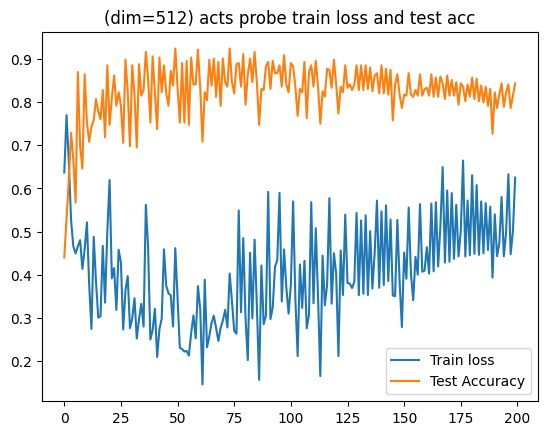

In [ ]:
plt.plot(epoch_train_loss, label="Train loss")
plt.plot(epoch_test_acc, label="Test Accuracy")
plt.legend()
plt.title("(dim=512) acts probe train loss and test acc")
print(epoch_test_acc)

##

Text(0.5, 1.0, '(dim=512) total loss')

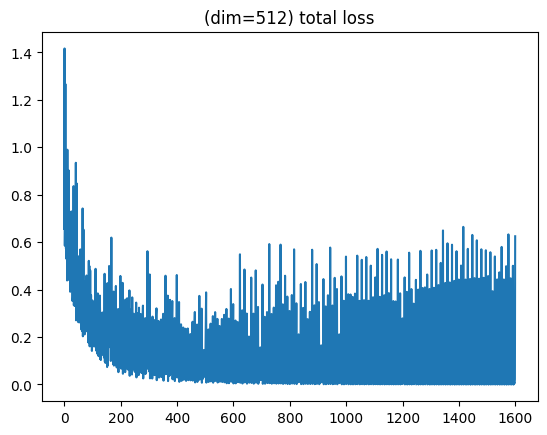

In [30]:
plt.plot(total_loss, label="total loss")
# plt.plot(epoch_test_acc, label="Test Accuracy")
# plt.legend()
plt.title("(dim=512) total loss")
# print(epoch_test_acc)

In [ ]:
print("test accuracy (top 3)", t.tensor(epoch_test_acc).topk(3)) # test accuracy seem to have peaked at 49/73
print("train loss (bottom 3)", t.tensor(epoch_train_loss).topk(3, largest=False))
# t.tensor(total_loss).topk(3)

# 65

test accuracy (top 3) torch.return_types.topk(
values=tensor([0.9245, 0.9245, 0.9219]),
indices=tensor([49, 73, 59]))
train loss (bottom 3) torch.return_types.topk(
values=tensor([0.1456, 0.1563, 0.1650]),
indices=tensor([ 61,  86, 113]))


### acts probe: 65 epoches

In [49]:
t.manual_seed(42)
probe = Probe(512)

epoch_train_loss = []
total_loss = []
epoch_test_acc = []
epoches = 65

# train_batches = batches[:-2]

for i in range(epoches): 
    probe, losses = train_probe(probe, train_batches)
    total_loss.extend(losses)
    epoch_train_loss.append(losses[-1])

    test_acc = test_probe(probe, batches=test_batches, seed=42)
    epoch_test_acc.append(test_acc)

In [108]:
test_probe(probe, batches=test_batches, seed=42)


0.8984375

Text(0.5, 1.0, 'Acts probe (dim=512) training plot (Final test accuracy = 0.8984) ')

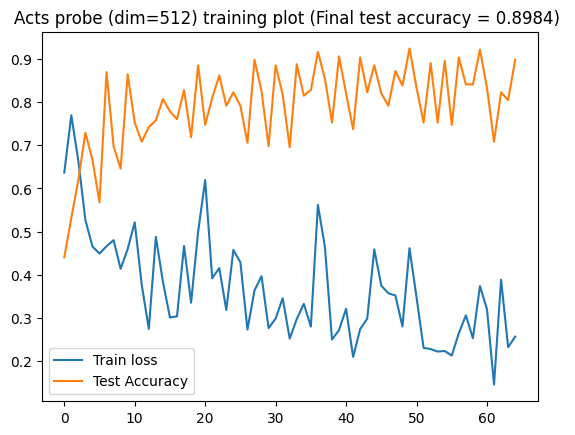

In [ ]:
plt.plot(epoch_train_loss, label="Train loss")
plt.plot(epoch_test_acc, label="Test Accuracy")
plt.legend()
plt.title(f"Acts probe (dim=512) training plot (Final test accuracy = {epoch_test_acc[-1]:.4f}) ")


#### acts probe recall

In [76]:
## recall score (harmful) = 0.823

harmful_acts = read_from_pt_gz("data_latents/test/acts/harmful_acts_512.pt.gz")
last_tok_acts_data = harmful_acts[:, -1, :].tolist()
label = t.ones(len(harmful_acts))
test_batches_harmful = data_loader(last_tok_acts_data, label)

recall = test_probe(probe, test_batches_harmful)
print('Recall', recall)

/Users/roselin/Desktop/locating_latent_rep_of_harm/utils/data_utils.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t.load(f)


Recall (0.8229166865348816, [tensor([1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1.]), tensor([1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.]), tensor([1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.]), tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1.]), tensor([1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), tensor([1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.]), tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.]), tensor([1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.]), tensor([1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0.]), tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.]), tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.])])


In [ ]:
## recall score (nonharmful) = 0.97
## better at nonharmful than harmful?

nonharmful_acts = read_from_pt_gz("data_latents/test/acts/nonharmful_acts_512.pt.gz")
last_tok_acts_data = nonharmful_acts[:, -1, :].tolist()

label = t.zeros(len(nonharmful_acts))
test_batches_nonharmful = data_loader(last_tok_acts_data, label)

test_probe(probe, test_batches_nonharmful)

/Users/roselin/Desktop/locating_latent_rep_of_harm/utils/data_utils.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t.load(f)


0.9739583134651184

In [ ]:
# recall (perturbed)
harmful_acts = read_from_pt_gz("data_latents/test_perturbed/acts/harmful_acts_512.pt.gz")
last_tok_acts_data = harmful_acts[:, -1, :].tolist()
label = t.ones(len(harmful_acts))
test_batches_harmful_perturbed = data_loader(last_tok_acts_data, label)

test_probe(probe, test_batches_harmful_perturbed)

# plt.plot(harmful_acts[:, -1, :].mean(0))

/Users/roselin/Desktop/locating_latent_rep_of_harm/utils/data_utils.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t.load(f)


0.0

In [109]:
filepath = "concept_probe/acts_probe/acts_probe.pth"
t.save(probe.state_dict(), filepath)
print('saved to ', filepath)


saved to  concept_probe/acts_probe/acts_probe.pth


#### TODO: 3 epoches?


In [111]:
t.manual_seed(42)
probe = Probe(512)

epoch_train_loss = []
total_loss = []
epoch_test_acc = []
epoches = 3

# train_batches = batches[:-2]

for i in range(epoches): 
    probe, losses = train_probe(probe, train_batches)
    total_loss.extend(losses)
    epoch_train_loss.append(losses[-1])

    test_acc = test_probe(probe, batches=test_batches, seed=42)
    epoch_test_acc.append(test_acc)

Text(0.5, 1.0, 'Acts probe (dim=512) training plot (Final test accuracy = 0.6198) ')

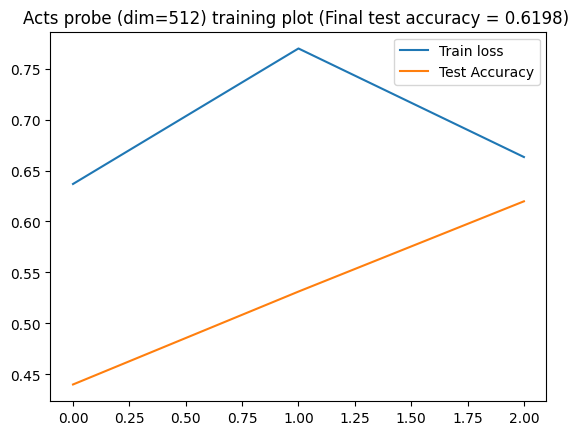

In [114]:
plt.plot(epoch_train_loss, label="Train loss")
plt.plot(epoch_test_acc, label="Test Accuracy")
plt.legend()
plt.title(f"Acts probe (dim=512) training plot (Final test accuracy = {epoch_test_acc[-1]:.4f}) ")


In [ ]:

# recall (harmful)
harmful_acts = read_from_pt_gz("data_latents/test/acts/harmful_acts_512.pt.gz")
last_tok_acts_data = harmful_acts[:, -1, :].tolist()
label = t.ones(len(harmful_acts))
test_batches_harmful = data_loader(last_tok_acts_data, label)

recall = test_probe(probe, test_batches_harmful)

# recall (perturbed)
harmful_acts = read_from_pt_gz("data_latents/test_perturbed/acts/harmful_acts_512.pt.gz")
last_tok_acts_data = harmful_acts[:, -1, :].tolist()
label = t.ones(len(harmful_acts))
test_batches_harmful_perturbed = data_loader(last_tok_acts_data, label)

perturbed_recall = test_probe(probe, test_batches_harmful_perturbed)
test_acc = test_probe(probe, batches=test_batches, seed=42)

print("test accuracy: ", test_acc)
print("recall: ", recall)
print("recall perturbed: ", perturbed_recall)

/Users/roselin/Desktop/locating_latent_rep_of_harm/utils/data_utils.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t.load(f)


test accuracy:  0.6197916865348816
recall:  1.0
recall perturbed:  0.9895833134651184


#### smaller batches

##### inspect

In [ ]:
def test_probe(probe, batches, seed=42):
    with t.no_grad():
        corrects = []

        for batch in batches:
            acts = batch[0]
            labels = batch[1]

            logits = probe(acts)
            preds = (logits > 0.0).long()

            corrects.append((preds == labels).float())
        return t.cat(corrects).mean().item(), corrects


In [ ]:
harmful_acts = read_from_pt_gz("data_latents/test/acts/harmful_acts_512.pt.gz")
last_tok_acts_data = harmful_acts[:, -1, :].tolist()
label = t.ones(len(harmful_acts))
test_batches_harmful = data_loader(last_tok_acts_data, label)

test_probe(probe, test_batches_harmful)

/Users/roselin/Desktop/locating_latent_rep_of_harm/utils/data_utils.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t.load(f)


(0.8229166865348816,
 [tensor([1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1.]),
  tensor([1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.]),
  tensor([1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.]),
  tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1.]),
  tensor([1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
  tensor([1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.]),
  tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.]),
  tensor([1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.]),
  tensor([1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
  tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0.]),
  tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.]),
  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.])])

In [70]:
test_probe(probe, test_batches_harmful)


(0.0,
 [tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])])

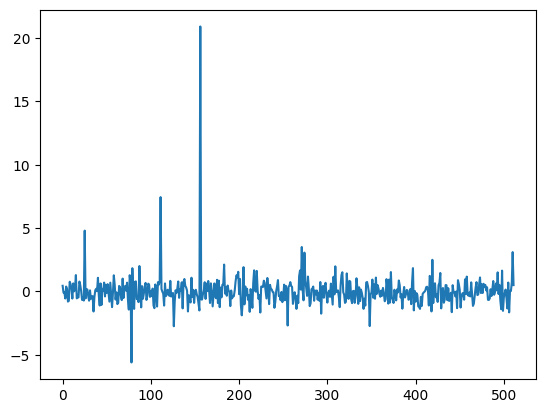

In [ ]:
## distribution 
## recall 
plt.plot(harmful_acts[:, -1, :].mean(0))

{'bodies': [<matplotlib.collections.PolyCollection at 0x29c2d9f50>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x28da8c590>,
 'cmins': <matplotlib.collections.LineCollection at 0x29cb204d0>,
 'cbars': <matplotlib.collections.LineCollection at 0x29cb2cbd0>}

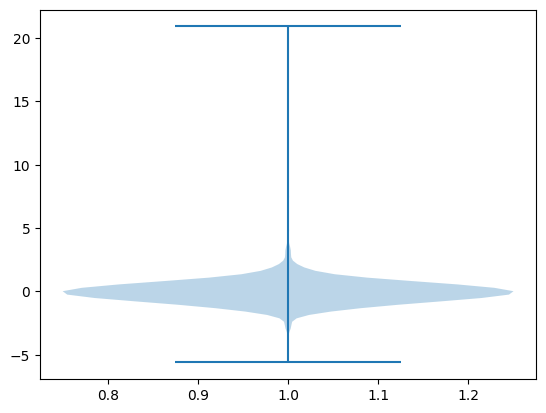

In [67]:
plt.violinplot(harmful_acts[:, -1, :].mean(0))

In [ ]:
from utils.probe_utils import load_probe

probe_90 = load_probe("concept_probe/probe_dim_512_test_acc_0.9062.pth")
# test_probe(probe_90, test_batches_harmful)
# bc this probe was trained on a diff distribution
# it doesnt do well on this?
# test_probe(probe_90, test_batches_nonharmful)
test_probe(probe_90, test_batches)

/Users/roselin/Desktop/locating_latent_rep_of_harm/utils/probe_utils.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t.load(filepath))


0.5026041865348816

In [ ]:
## try reducing the data and retrain

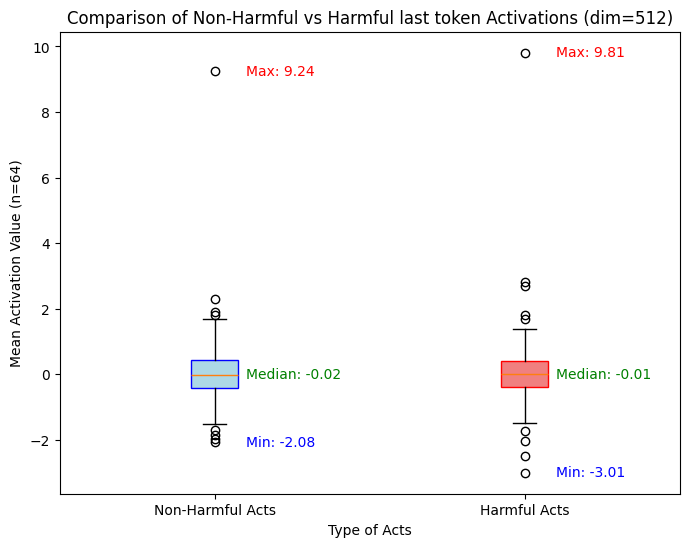

In [25]:
## mean for final token

nonharmful_data = nonharmful_acts[:, -1, :].mean(0)  # mean along axes 0 and 1 for nonharmful_acts
harmful_data = harmful_acts[:, -1, :].mean(0)      # mean along axes 0 and 1 for harmful_acts

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Plot nonharmful_acts boxplot at position 1 with a custom color
box_nonharmful = plt.boxplot(nonharmful_data, positions=[1], patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'))

# Plot harmful_acts boxplot at position 2 with a custom color
box_harmful = plt.boxplot(harmful_data, positions=[2], patch_artist=True, boxprops=dict(facecolor='lightcoral', color='red'))

# Function to annotate max, min, and median values
def annotate_boxplot(data, pos):
    # Extract the statistics from the boxplot
    median = t.median(data)
    minimum = t.min(data)
    maximum = t.max(data)

    plt.text(pos + 0.1, minimum, f"Min: {minimum:.2f}", ha='left', va='center', fontsize=10, color='blue')
    plt.text(pos + 0.1, median, f"Median: {median:.2f}", ha='left', va='center', fontsize=10, color='green')
    plt.text(pos + 0.1, maximum, f"Max: {maximum:.2f}", ha='left', va='center', fontsize=10, color='red')

# Annotate both boxplots
annotate_boxplot(nonharmful_data, 1)
annotate_boxplot(harmful_data, 2)

# Set the x-axis labels
plt.xticks([1, 2], ['Non-Harmful Acts', 'Harmful Acts'])

# Optional: Add labels and title
plt.xlabel('Type of Acts')
plt.ylabel('Mean Activation Value (n=64)')
plt.title('Comparison of Non-Harmful vs Harmful last token Activations (dim=512)')

# Display the plot
plt.show()

## quite similar

In [ ]:
nonharmful_data = nonharmful_acts.mean(1).mean(0)  # mean along axes 0 and 1 for nonharmful_acts
harmful_data = harmful_acts.mean(1).mean(0)       # mean along axes 0 and 1 for harmful_acts

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Plot nonharmful_acts boxplot at position 1 with a custom color
box_nonharmful = plt.boxplot(nonharmful_data, positions=[1], patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'))

# Plot harmful_acts boxplot at position 2 with a custom color
box_harmful = plt.boxplot(harmful_data, positions=[2], patch_artist=True, boxprops=dict(facecolor='lightcoral', color='red'))

# Function to annotate max, min, and median values
def annotate_boxplot(data, pos):
    # Extract the statistics from the boxplot
    median = t.median(data)
    minimum = t.min(data)
    maximum = t.max(data)

    plt.text(pos + 0.1, minimum, f"Min: {minimum:.2f}", ha='left', va='center', fontsize=10, color='blue')
    plt.text(pos + 0.1, median, f"Median: {median:.2f}", ha='left', va='center', fontsize=10, color='green')
    plt.text(pos + 0.1, maximum, f"Max: {maximum:.2f}", ha='left', va='center', fontsize=10, color='red')

# Annotate both boxplots
annotate_boxplot(nonharmful_data, 1)
annotate_boxplot(harmful_data, 2)

# Set the x-axis labels
plt.xticks([1, 2], ['Non-Harmful Acts', 'Harmful Acts'])

# Optional: Add labels and title
plt.xlabel('Type of Acts')
plt.ylabel('Mean Value across tokens')
plt.title('Comparison of Non-Harmful vs Harmful Activation Values for (dim=512) averaged over n=64 prompts each')

# Display the plot
plt.show()

## quite similar

#### sparse acts probe
- todo: could re-run to get sparse acts - to viz



In [ ]:
# def test_probe(probe, batches, seed=42):
#     with t.no_grad():
#         corrects = []

#         for batch in batches:
#             acts = batch[0]
#             labels = batch[1]

#             logits = probe(acts)
#             preds = (logits > 0.0).long()

#             corrects.append((preds == labels).float())
#         return t.cat(corrects).mean().item()

In [116]:
### get train acts
nonharmful_acts = read_from_pt_gz("data_latents/train/sparse_acts/nonharmful_sparse_acts_32768.pt.gz")
harmful_acts = read_from_pt_gz("data_latents/train/sparse_acts/harmful_sparse_acts_32768.pt.gz")

last_tok_acts_data = t.cat((nonharmful_acts[:, -1, :], harmful_acts[:, -1, :]), dim=0).tolist()
label = t.cat( (t.zeros(len(nonharmful_acts)) , t.ones(len(harmful_acts))) )

train_batches = data_loader(last_tok_acts_data, label)

In [117]:
## get test acts
nonharmful_acts = read_from_pt_gz("data_latents/test/sparse_acts/nonharmful_sparse_acts_32768.pt.gz")
harmful_acts = read_from_pt_gz("data_latents/test/sparse_acts/harmful_sparse_acts_32768.pt.gz")

last_tok_acts_data = t.cat((nonharmful_acts[:, -1, :], harmful_acts[:, -1, :]), dim=0).tolist()
label = t.cat( (t.zeros(len(nonharmful_acts)) , t.ones(len(harmful_acts))) )
test_batches = data_loader(last_tok_acts_data, label)
len(test_batches)

24

In [87]:
t.manual_seed(42)
probe = Probe(32768)

epoch_train_loss = []
total_loss = []
epoch_test_acc = []
epoches = 65

# train_batches = batches[:-2]

for i in range(epoches): 
    probe, losses = train_probe(probe, train_batches)
    total_loss.extend(losses)
    epoch_train_loss.append(losses[-1])

    test_acc = test_probe(probe, batches=test_batches, seed=42)
    epoch_test_acc.append(test_acc)

In [91]:
t.tensor(epoch_test_acc).topk(3)

torch.return_types.topk(
values=tensor([0.7812, 0.7734, 0.7682]),
indices=tensor([3, 2, 4]))

Text(0.5, 1.0, 'Sparse acts probe training plot (Final test accuracy = 0.7318) ')

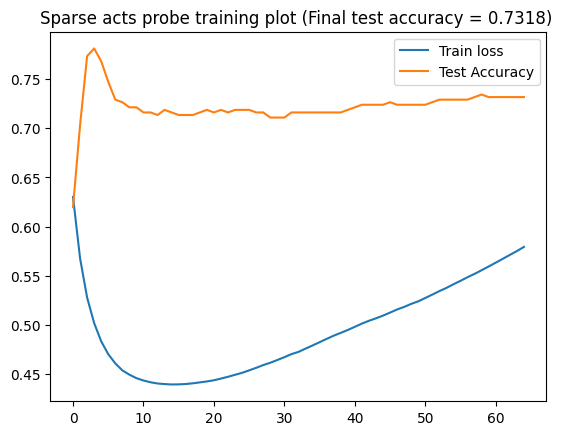

In [89]:
plt.plot(epoch_train_loss, label="Train loss")
plt.plot(epoch_test_acc, label="Test Accuracy")
plt.legend()
plt.title(f"Sparse acts probe training plot (Final test accuracy = {epoch_test_acc[-1]:.4f}) ")


In [92]:
## test acts 
## accuracy
test_probe(probe, batches=test_batches, seed=42)


0.7317708134651184

In [93]:
harmful_acts = read_from_pt_gz("data_latents/test/sparse_acts/harmful_sparse_acts_32768.pt.gz")
last_tok_acts_data = harmful_acts[:, -1, :].tolist()
label = t.ones(len(harmful_acts))
test_batches_harmful = data_loader(last_tok_acts_data, label)

recall = test_probe(probe, test_batches_harmful)
print("test harmful recall:", recall)

/Users/roselin/Desktop/locating_latent_rep_of_harm/utils/data_utils.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t.load(f)


test harmful recall: 0.6927083134651184


In [94]:
harmful_acts = read_from_pt_gz("data_latents/test_perturbed/sparse_acts/harmful_sparse_acts_32768.pt.gz")
last_tok_acts_data = harmful_acts[:, -1, :].tolist()
label = t.ones(len(harmful_acts))
test_batches_harmful = data_loader(last_tok_acts_data, label)

recall = test_probe(probe, test_batches_harmful)
print("test harmful perturbed recall:", recall)

test harmful perturbed recall: 0.5729166865348816


In [ ]:
len(test_batches_harmful[0][0])
# 12 * 16

16

In [101]:
## test nonharmful

nonharmful_acts = read_from_pt_gz("data_latents/test/sparse_acts/nonharmful_sparse_acts_32768.pt.gz")
last_tok_acts_data = nonharmful_acts[:, -1, :].tolist()

label = t.zeros(len(nonharmful_acts))
test_batches_nonharmful = data_loader(last_tok_acts_data, label)

test_probe(probe, test_batches_nonharmful)

/Users/roselin/Desktop/locating_latent_rep_of_harm/utils/data_utils.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t.load(f)


0.7708333134651184

In [102]:
filepath = "concept_probe/sparse_acts_probe/sparse_acts_probe.pth"
t.save(probe.state_dict(), filepath)
print('saved to ', filepath)


saved to  concept_probe/sparse_acts_probe/sparse_acts_probe.pth


#### 3 epoches: 

In [118]:
t.manual_seed(42)
probe = Probe(32768)

epoch_train_loss = []
total_loss = []
epoch_test_acc = []
epoches = 3

# train_batches = batches[:-2]

for i in range(epoches): 
    probe, losses = train_probe(probe, train_batches)
    total_loss.extend(losses)
    epoch_train_loss.append(losses[-1])

    test_acc = test_probe(probe, batches=test_batches, seed=42)
    epoch_test_acc.append(test_acc)

Text(0.5, 1.0, 'Sparse Acts probe training plot (Final test accuracy = 0.7734) ')

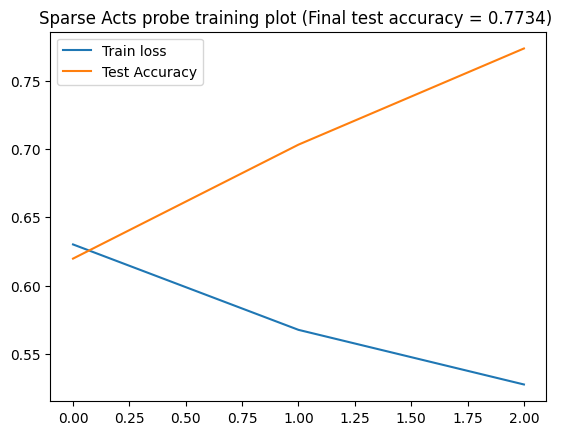

In [119]:
plt.plot(epoch_train_loss, label="Train loss")
plt.plot(epoch_test_acc, label="Test Accuracy")
plt.legend()
plt.title(f"Sparse Acts probe training plot (Final test accuracy = {epoch_test_acc[-1]:.4f}) ")



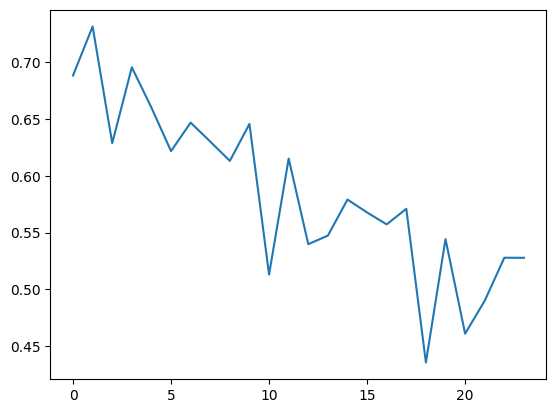

In [121]:
plt.plot(total_loss)

In [120]:
# recall (harmful)
harmful_acts = read_from_pt_gz("data_latents/test/sparse_acts/harmful_sparse_acts_32768.pt.gz")
last_tok_acts_data = harmful_acts[:, -1, :].tolist()
label = t.ones(len(harmful_acts))
test_batches_harmful = data_loader(last_tok_acts_data, label)

recall = test_probe(probe, test_batches_harmful)

# recall (perturbed)
harmful_acts = read_from_pt_gz("data_latents/test_perturbed/sparse_acts/harmful_sparse_acts_32768.pt.gz")
last_tok_acts_data = harmful_acts[:, -1, :].tolist()
label = t.ones(len(harmful_acts))
test_batches_harmful_perturbed = data_loader(last_tok_acts_data, label)

perturbed_recall = test_probe(probe, test_batches_harmful_perturbed)

test_acc = test_probe(probe, batches=test_batches, seed=42)

print("test accuracy: ", test_acc)
print("recall: ", recall)
print("recall perturbed: ", perturbed_recall)

test accuracy:  0.7734375
recall:  0.9114583134651184
recall perturbed:  0.796875


In [122]:
nonharmful_acts = read_from_pt_gz("data_latents/test/sparse_acts/nonharmful_sparse_acts_32768.pt.gz")
last_tok_acts_data = nonharmful_acts[:, -1, :].tolist()

label = t.zeros(len(nonharmful_acts))
test_batches_nonharmful = data_loader(last_tok_acts_data, label)

test_probe(probe, test_batches_nonharmful)

# t.save(probe.state_dict(), filepath)
# print('saved to ', filepath)


/Users/roselin/Desktop/locating_latent_rep_of_harm/utils/data_utils.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t.load(f)


0.6354166865348816

In [124]:
filepath = "concept_probe/sparse_acts_probe/sparse_acts_probe_3_epoches.pth"
t.save(probe.state_dict(), filepath)
print('saved to ', filepath)


saved to  concept_probe/sparse_acts_probe/sparse_acts_probe_3_epoches.pth


In [ ]:
### train probe, test probe

#### causal probe

In [ ]:
### get train ablation effects, test ablation effects

In [3]:
### get train sparse acts, test sparse acts
nonharmful_causal_dist = read_from_pt_gz("sparse_acts/train/nonharmful_acts_ablation_effects")
harmful_causal_dist = read_from_pt_gz("sparse_acts/train/harmful_acts_ablation_effects")


/Users/roselin/Desktop/locating_latent_rep_of_harm/utils/data_utils.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t.load(f)


In [7]:
harmful_causal_dist.shape

torch.Size([32768])

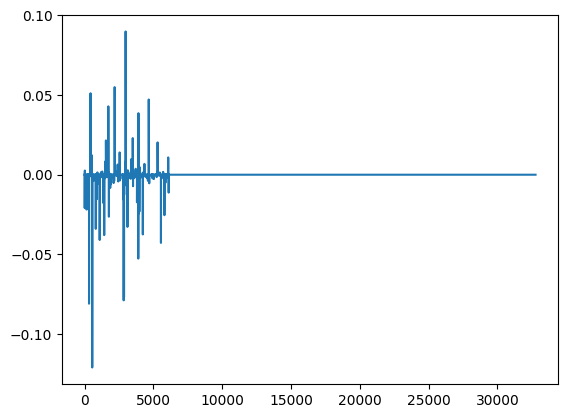

In [6]:
import matplotlib.pyplot as plt 
plt.plot(nonharmful_causal_dist.detach().numpy())

In [ ]:
# last_tok_acts_data = t.cat((nonharmful_acts[:, -1, :], harmful_acts[:, -1, :]), dim=0).tolist()
# label = train_nonharmful[1] + train_harmful[1]
# train_batches = data_loader(last_tok_acts_data, label)
